## Import Statements

In [51]:
import numpy as np

from sklearn.decomposition import PCA

import pandas as pd

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [52]:
data_path = '../Data/'

filenames = [
#     'CM2014_edit.csv',
    'CM2015_edit.csv',
    'CM2016_edit.csv',
    'CM2017_edit.csv',
    'CM2018_edit.csv',
    'mdcp.csv',
    'major_ion.csv',
    'Weather_Data.csv'
]

# cla_2014 = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2015_raw = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2016_raw = pd.read_csv(data_path + filenames[1], low_memory=False)
cla_2017_raw = pd.read_csv(data_path + filenames[2], low_memory=False)
cla_2018_raw = pd.read_csv(data_path + filenames[3], low_memory=False)
mdcp_raw = pd.read_csv(data_path + filenames[4], low_memory=False)    # Mendota buoy
weather_raw = pd.read_csv(data_path + filenames[6], error_bad_lines=False, low_memory=False)

## Clean Data

### CLA Data

In [53]:
keep15 = [     # features to keep for years 2015-2017
    'correct_timestamp',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'lat',
    'long'
]

keep18 = [    # features to keep for 2018
    'sample_collection_time',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitiude',
    'longitude'
]

rename15 = {   # rename features for 2015-2017
    'collectionSiteId': 'site',
    'lat': 'latitude',
    'long': 'longitude',
    'correct_timestamp': 'date'
}

rename18 = {   # renamce features for 2018
    'collectionSiteId': 'site',
    'sample_collection_time': 'date',
    'latitiude': 'latitude'
}

cla_2015 = cla_2015_raw[keep15]
cla_2016 = cla_2016_raw[keep15]
cla_2017 = cla_2017_raw[keep15]
cla_2018 = cla_2018_raw[keep18]

cla_2015.rename(rename15, axis='columns', inplace=True)
cla_2016.rename(rename15, axis='columns', inplace=True)
cla_2017.rename(rename15, axis='columns', inplace=True)
cla_2018.rename(rename18, axis='columns', inplace=True)

# change data types
numeric = [    # list of numeric features
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitude',
    'longitude'
]

# convert data types
features = cla_2015.columns.values

for feat in features:
    if feat in numeric:
        cla_2015[feat] = pd.to_numeric(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_numeric(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_numeric(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_numeric(cla_2018[feat], errors='coerce')
    
    if feat in ['site', 'lake']:
        cla_2015[feat] = cla_2015[feat].astype(str)
        cla_2016[feat] = cla_2016[feat].astype(str)
        cla_2017[feat] = cla_2017[feat].astype(str)
        cla_2018[feat] = cla_2018[feat].astype(str)
    
    if feat == 'date':
        cla_2015[feat] = pd.to_datetime(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_datetime(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_datetime(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_datetime(cla_2018[feat], errors='coerce')
        
# remove nans
cla_2015.dropna(axis='rows', how='any', inplace=True)
cla_2016.dropna(axis='rows', how='any', inplace=True)
cla_2017.dropna(axis='rows', how='any', inplace=True)
cla_2018.dropna(axis='rows', how='any', inplace=True)

# remove any data point not on lake mendota
cla_2015 = cla_2015[cla_2015['lake'].str.contains('Mendota')]
cla_2016 = cla_2016[cla_2016['lake'].str.contains('Mendota')]
cla_2017 = cla_2017[cla_2017['lake'].str.contains('Mendota')]
cla_2018 = cla_2018[cla_2018['lake'].str.contains('Mendota')]

# set date as index
cla_2015.set_index('date', inplace=True)
cla_2016.set_index('date', inplace=True)
cla_2017.set_index('date', inplace=True)
cla_2018.set_index('date', inplace=True)

# sort data by dates
cla_2015.sort_values(by='date', inplace=True)
cla_2016.sort_values(by='date', inplace=True)
cla_2017.sort_values(by='date', inplace=True)
cla_2018.sort_values(by='date', inplace=True)

# resample, ffill and bfill
cla_2015 = cla_2015.resample('D').mean()
cla_2015.ffill(inplace=True)
cla_2015.bfill(inplace=True)

for date in cla_2015.index:
    if cla_2015.loc[date, 'algalBloomSheen'] > 0:
        cla_2015.loc[date, 'algalBloomSheen'] = 1

cla_2016 = cla_2016.resample('D').mean()
cla_2016.ffill(inplace=True)
cla_2016.bfill(inplace=True)

for date in cla_2016.index:
    if cla_2016.loc[date, 'algalBloomSheen'] > 0:
        cla_2016.loc[date, 'algalBloomSheen'] = 1

cla_2017 = cla_2017.resample('D').mean()
cla_2017.ffill(inplace=True)
cla_2017.bfill(inplace=True)

for date in cla_2017.index:
    if cla_2017.loc[date, 'algalBloomSheen'] > 0:
        cla_2017.loc[date, 'algalBloomSheen'] = 1

cla_2018 = cla_2018.resample('D').mean()
cla_2018.ffill(inplace=True)
cla_2018.bfill(inplace=True)

for date in cla_2018.index:
    if cla_2018.loc[date, 'algalBloomSheen'] > 0:
        cla_2018.loc[date, 'algalBloomSheen'] = 1
        
# only keep the dates of the official sampling season of each year
# cla_2015 = cla_2015[(cla_2015.index >= '2015-5-18') & (cla_2015.index <= '2015-9-4')]
# cla_2016 = cla_2016[(cla_2016.index >= '2016-5-25') & (cla_2016.index <= '2016-9-4')]
# cla_2017 = cla_2017[(cla_2017.index >= '2017-5-25') & (cla_2017.index <= '2017-9-4')]
# cla_2018 = cla_2018[(cla_2018.index >= '2018-5-25') & (cla_2018.index <= '2018-9-4')]

### MDCP Data

In [54]:
keep_mdcp = [
    'sampledate',
    'sampletime',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor',
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]

mdcp = mdcp_raw[keep_mdcp]
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

mdcp['date'] = mdcp['sampledate'] + ' ' + mdcp['sampletime']
mdcp['date'] = pd.to_datetime(mdcp['date'], errors='coerce')
mdcp.dropna(axis='rows', how='any', inplace=True)

mdcp = mdcp[[
    'date',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor', 
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]]
mdcp.set_index('date', inplace=True)

mdcp = mdcp.resample('D').mean()
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

### Weather Data

In [55]:
keep_weather = [
    'DATE',
    'REPORTTPYE',
    'DAILYMaximumDryBulbTemp',
    'DAILYMinimumDryBulbTemp',
    'DAILYAverageDryBulbTemp',
    'DAILYDeptFromNormalAverageTemp',
    'DAILYAverageDewPointTemp',
    'DAILYAverageWetBulbTemp',
    'DAILYPrecip',
    'DAILYAverageStationPressure',
    'DAILYAverageSeaLevelPressure'
]

weather = weather_raw[keep_weather]
# weather['REPORTTPYE'].dropna(axis='rows', how='any', inplace=True)
weather = weather.iloc[:-1]  # remove last entry since it has NaN in REPORTTPYE

weather = weather[weather['REPORTTPYE'].str.contains('SOD')]    # only keep summary of day (SOD) info
weather = weather.drop(['REPORTTPYE'], axis='columns')
weather['DATE'] = pd.to_datetime(weather['DATE'], errors='coerce')

weather.set_index('DATE', inplace=True)
weather = weather.resample('D').ffill()
weather.ffill(inplace=True)
weather.bfill(inplace=True)

## Join CLA, MDCP, and Weather Data

In [56]:
# Append CLA data
cla = cla_2015.append(cla_2016)
cla = cla.append(cla_2017)
cla = cla.append(cla_2018)

# Insert MDCP data
data = cla.join(mdcp, how='inner')

# Insert weather data
data = data.join(weather, how='inner')

# sine/cosine transformation of month of year and wind direction
data['cos_month'] = np.cos(2 * np.pi * (data.index.month.values / 12))
data['sin_month'] = np.sin(2 * np.pi * (data.index.month.values / 12))

data['cos_wind_dir'] = np.cos(2 * np.pi * (data['wind_dir'] / 12))
data['sin_wind_dir'] = np.sin(2 * np.pi * (data['wind_dir'] / 12))
data = data.drop(['wind_dir'], axis='columns')

# Replace 'T' and 's' in 'DAILYPrecip' column
for date in data.index:
    if 'T' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0.01
    elif 's' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0

# Make every feature numeric
for col in data.columns.values:
    if type(data[col].values[0]) != np.float64:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
# create indicator features for whether there was rain or a bloom one day ago, or within three days or a week ago
# precip = (data['DAILYPrecip'] > 0).astype(int)   # convert precipitation to boolean values
# data['DAILYPrecip_one_day'] = precip.shift(1)
# data['DAILYPrecip_three_day'] = precip.rolling(window=3, min_periods=1).sum()
# data['DAILYPrecip_one_week'] = precip.rolling(window=7, min_periods=1).sum()

# data['algalBloomSheen_one_day'] = data['algalBloomSheen'].shift(1)
# data['algalBloomSheen_three_day'] = data[['algalBloomSheen']].shift(1).rolling(3).sum()
# data['algalBloomSheen_one_week'] = data[['algalBloomSheen']].shift(1).rolling(7).sum()

# shift algalbloomsheen by -1 to predict next day algal bloom
data['DAILYPrecip_one_day'] = data['DAILYPrecip']
data['DAILYPrecip_three_day'] = data['DAILYPrecip'].rolling(window=3, min_periods=1).sum()
data['DAILYPrecip_one_week'] = data['DAILYPrecip'].rolling(window=7, min_periods=1).sum()
precip = (data['DAILYPrecip'] > 0).astype(int)
data['COUNTPrecip_one_day'] = precip
data['COUNTPrecip_three_day'] = precip.rolling(window=3, min_periods=1).sum()
data['COUNTPrecip_one_week'] = precip.rolling(window=7, min_periods=1).sum()
data['algalBloomSheen_one_day'] = data['algalBloomSheen']
data['algalBloomSheen_three_day'] = data[['algalBloomSheen']].rolling(3, min_periods=1).sum()
data['algalBloomSheen_one_week'] = data[['algalBloomSheen']].rolling(7, min_periods=1).sum()
data['algalBloomSheen'] = data['algalBloomSheen'].shift(-1)

data.dropna(axis='rows', how='any', inplace=True)

# display(data[['DAILYPrecip',
#       'DAILYPrecip_one_day',
#       'DAILYPrecip_three_day',
#       'DAILYPrecip_one_week',
#       'algalBloomSheen',
#       'algalBloomSheen_one_day',
#       'algalBloomSheen_three_day',
#       'algalBloomSheen_one_week'
#      ]].head(15))

labels = data[['algalBloomSheen']].astype(int)
data = data.drop(['latitude', 'longitude', 'algalBloom', 'algalBloomSheen', 'DAILYPrecip'], axis='columns')

In [57]:
data.head()

,turbidity,air_temp,rel_hum,wind_speed,chlor,phycocyanin,do_raw,do_sat,do_wtemp,pco2_ppm,...,sin_wind_dir,DAILYPrecip_one_day,DAILYPrecip_three_day,DAILYPrecip_one_week,COUNTPrecip_one_day,COUNTPrecip_three_day,COUNTPrecip_one_week,algalBloomSheen_one_day,algalBloomSheen_three_day,algalBloomSheen_one_week
2015-05-15,37.00,8.524789,69.287973,4.659442,1625.863129,494.934952,9.038789,87.944626,14.124816,245.5,...,-0.340279,0.12,0.12,0.12,1,1.0,1.0,0.0,0.0,0.0
2015-05-16,37.00,8.524789,69.287973,4.659442,1625.863129,494.934952,9.038789,87.944626,14.124816,245.5,...,-0.340279,0.03,0.15,0.15,1,2.0,2.0,0.0,0.0,0.0
2015-05-17,54.00,8.524789,69.287973,4.659442,1625.863129,494.934952,9.038789,87.944626,14.124816,245.5,...,-0.340279,0.01,0.16,0.16,1,3.0,3.0,0.0,0.0,0.0
2015-05-18,66.00,8.524789,69.287973,4.659442,1625.863129,494.934952,9.038789,87.944626,14.124816,245.5,...,-0.340279,1.57,1.61,1.73,1,3.0,4.0,0.0,0.0,0.0
2015-05-19,101.25,8.524789,69.287973,4.659442,1625.863129,494.934952,9.038789,87.944626,14.124816,245.5,...,-0.340279,0.00,1.58,1.73,0,2.0,4.0,0.0,0.0,0.0


## Save File

In [58]:
# append labels to first column of data set
data.insert(loc=0, column='label', value=labels)
data.to_json('../Data/data.json')

# Data Visualization

## PCA

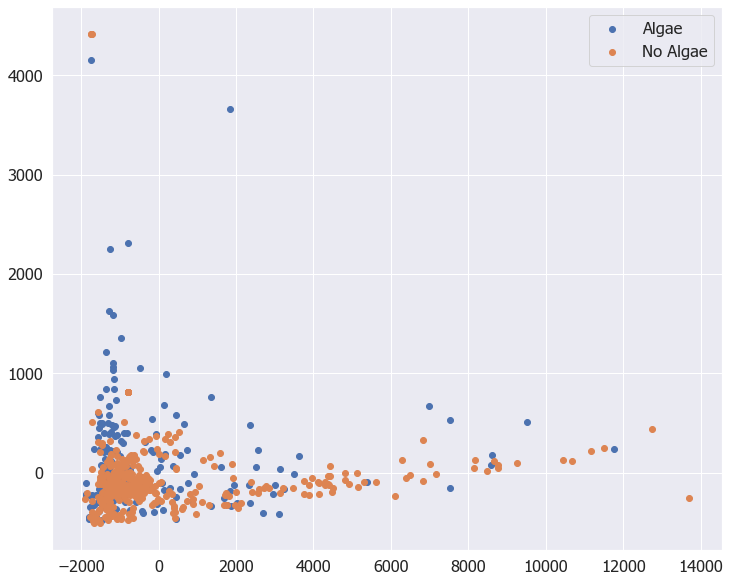

In [59]:
pca_fit = PCA(n_components=2, svd_solver='full')
X_pca = pca_fit.fit_transform(data)
X_pca = pd.DataFrame(X_pca)

pos_idx = labels[labels['algalBloomSheen'] > 0].index
pos = pd.DataFrame([X_pca.iloc[labels.index.get_loc(pos_idx[i])] for i in range(len(pos_idx))])   # positive class

neg_idx = labels[labels['algalBloomSheen'] < 1].index
neg = pd.DataFrame([X_pca.iloc[labels.index.get_loc(neg_idx[i])] for i in range(len(neg_idx))])   # negative class

plt.figure(figsize=(12, 10))
plt.scatter(pos[0], pos[1], label='Algae')
plt.scatter(neg[0], neg[1], label='No Algae')
plt.grid(True)
plt.legend(loc='best')
plt.show()


## Feature Analysis

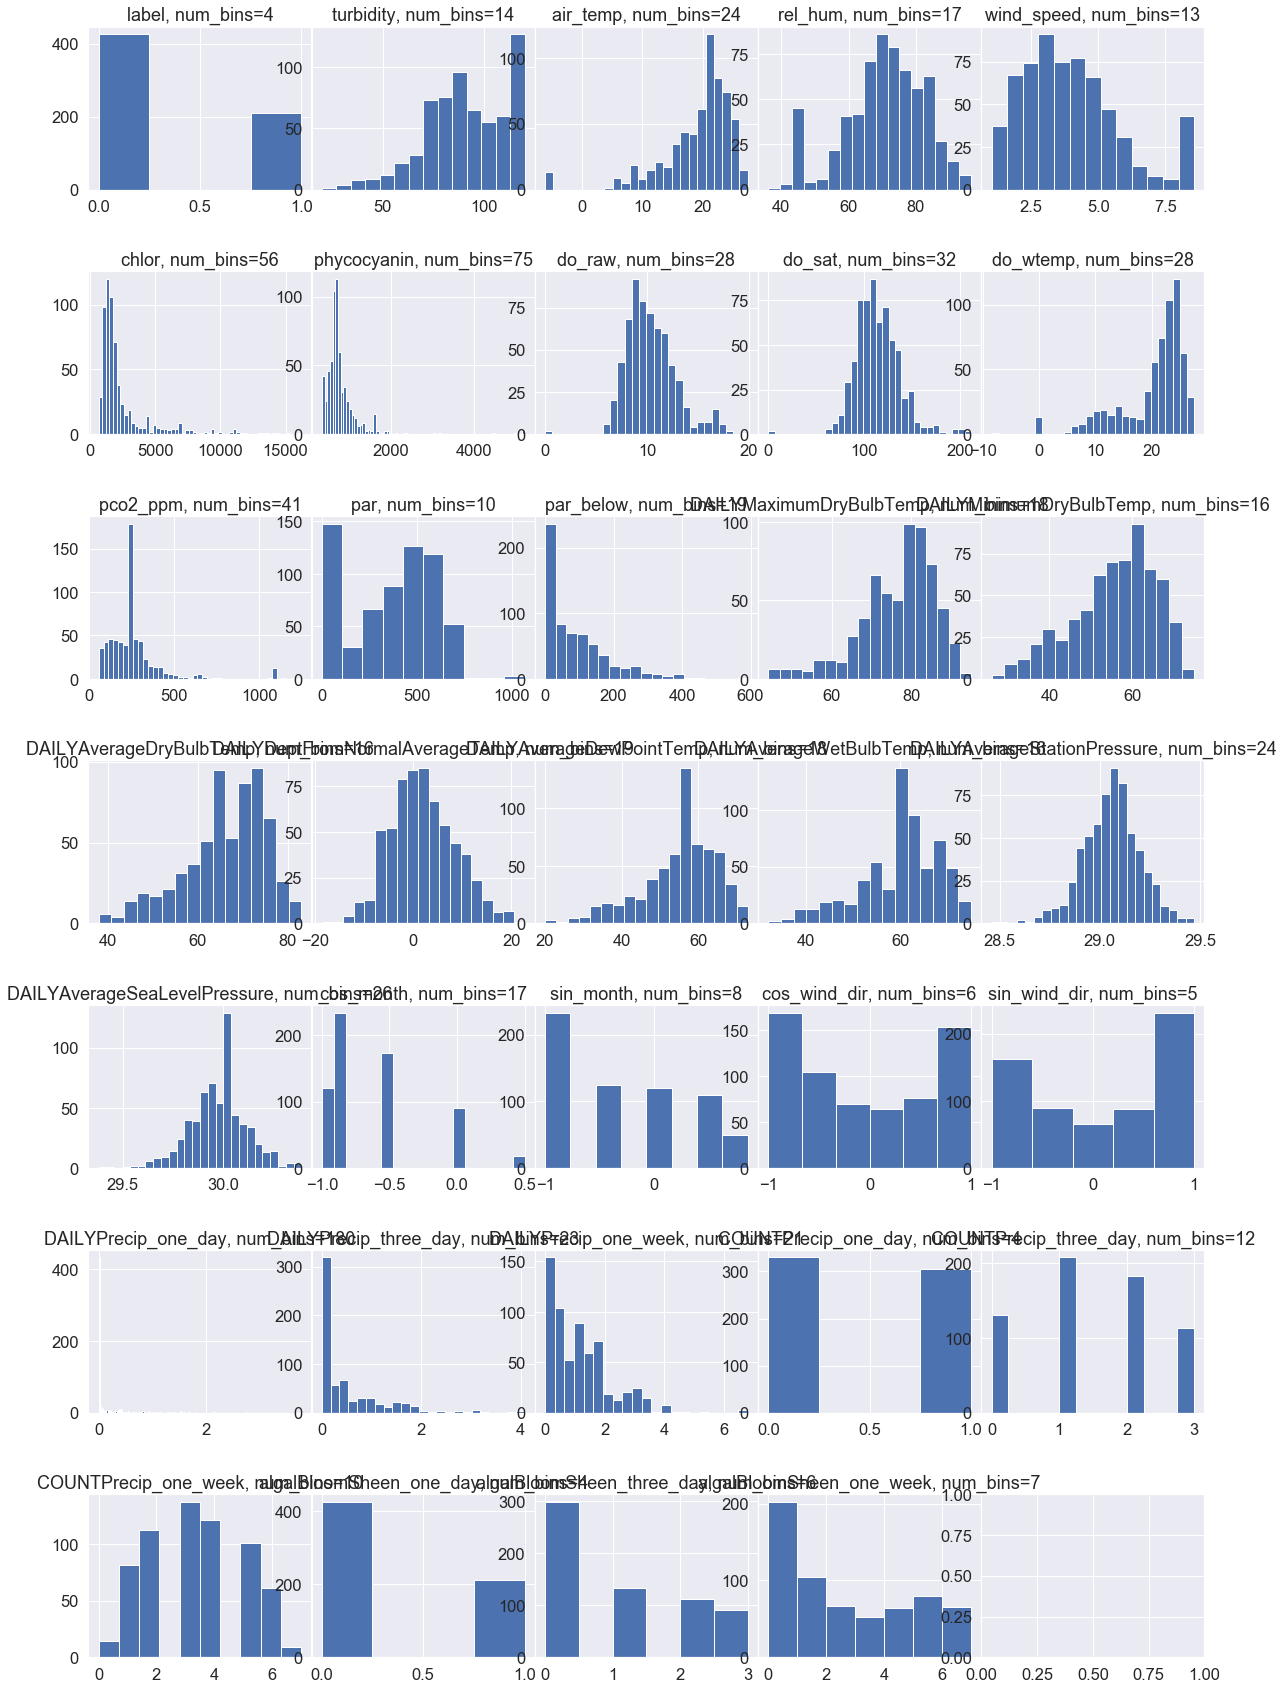

In [50]:
fig, axs = plt.subplots(7, 5, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
n = data.shape[0]

for i in range(data.shape[1]):
    # use Freedman-Diaconis rule to determine number of bins: h=2*IQR*n^(-1/3) ==> # bins = (max-min)/h
    iqr = data.iloc[:, i].quantile(0.75) - data.iloc[:, i].quantile(0.25)
    h = 2*iqr*(n**(-1/3))
    num_bins = int((data.iloc[:, i].max() - data.iloc[:, i].min()) / h)
    
    axs[i].hist(data.iloc[:, i], bins=num_bins)
    axs[i].set_title(data.columns[i] + ', num_bins=' + str(num_bins))

## Correlation

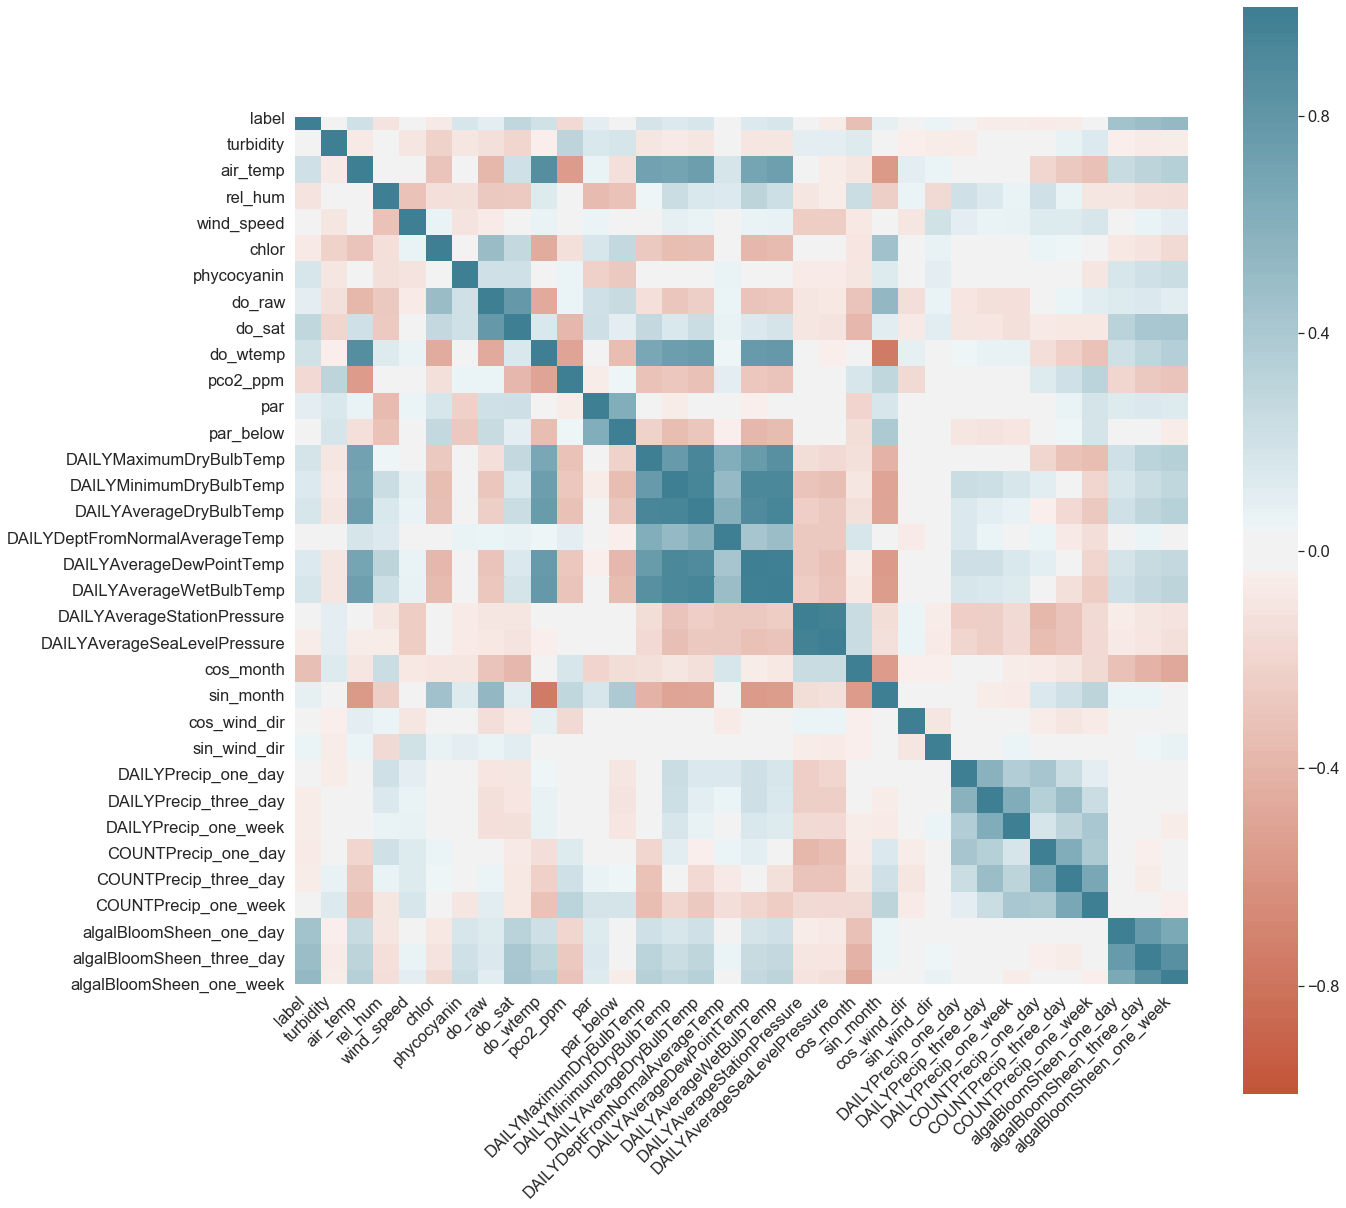

In [60]:
corr = data.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);